<a href="https://colab.research.google.com/github/RipeMangoBox/BlogLearning/blob/master/vae_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Created by 苏神

### Step 1 - SetUP

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

### Step 2 - Configurations

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 50

# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### Step 3 - Decoder

In [4]:
# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### Step 4 - Model

In [5]:
# 建立模型
vae = Model(x, x_decoded_mean)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                              

### Step 5 - Encoder

In [6]:
# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

### Step 6 - Latent Visualization

100/100 [==============================] - 1s 4ms/step


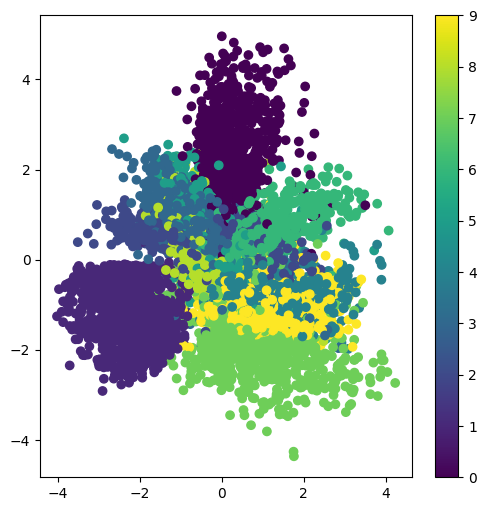

In [7]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

### Step 7 - Generator

In [8]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### Step 8 - Results

1/1 [==============================] - 0s 21ms/step


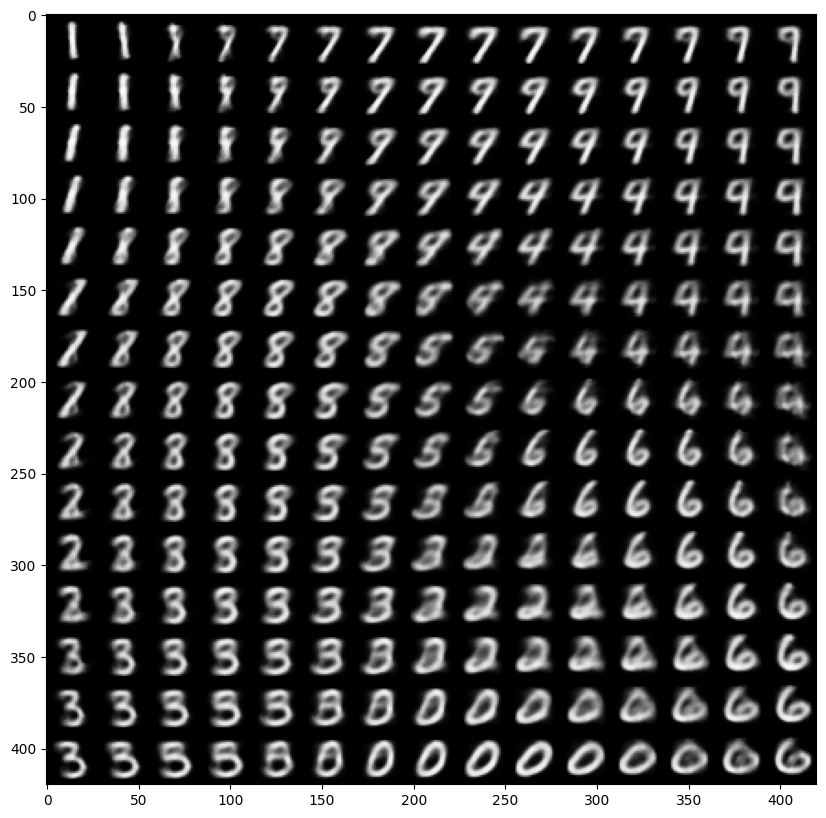

In [9]:
# 观察隐变量的两个维度变化是如何影响输出结果的
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()